In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from torchaudio import datasets

from loader import collate_function
from models import DSVAE

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
torch.mps.empty_cache()

Using device mps


In [ ]:
def kld_with_any(mean_c, logvar_c, mean_wav, var_wav):
    return 0.5 * (
        torch.log(var_wav / logvar_c)
        + (logvar_c + (mean_c - mean_wav) ** 2) / var_wav
        - 1
    )


def kld_with_normal(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())


def recon_loss(x, recon_x):
    return F.mse_loss(recon_x, x)


def loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c):
    return (
        recon_loss(x, recon_x)
        + kld_with_normal(mean_s, logvar_s)
        + kld_with_normal(mean_c, logvar_c)
    )

In [4]:
train_data = datasets.VCTK_092("./", download=True)
train_data_loader = DataLoader(
    train_data,
    batch_size=2,
    collate_fn=lambda batch: collate_function(batch),
    sampler=RandomSampler(train_data, num_samples=400)
)

In [5]:
model = DSVAE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2
losses = []

In [ ]:
torch.mps.empty_cache()
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(train_data_loader):
        x = x.to(device)
        optimizer.zero_grad()

        recon_x, mean_s, logvar_s, mean_c, logvar_c = model(x)
        loss = loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(train_data_loader)}, Loss {loss.item():.4f}")

    avg = train_loss / len(train_data_loader)
    losses.append(avg)

    print(f"Epoch {epoch+1}, Loss: {avg:.4f}")

print("Done!")

Epoch 1, Batch 1/200, Loss 8055.9111
Epoch 1, Batch 2/200, Loss 8565.6826
Epoch 1, Batch 3/200, Loss 8603.9727
Epoch 1, Batch 4/200, Loss 8435.8057
Epoch 1, Batch 5/200, Loss 8174.0981
Epoch 1, Batch 6/200, Loss 7683.6870
Epoch 1, Batch 7/200, Loss 7433.7720
Epoch 1, Batch 8/200, Loss 6811.2290
Epoch 1, Batch 9/200, Loss 6075.8379
Epoch 1, Batch 10/200, Loss 4916.7505
Epoch 1, Batch 11/200, Loss 4187.6963
Epoch 1, Batch 12/200, Loss 2805.6855
Epoch 1, Batch 13/200, Loss 2101.2732
Epoch 1, Batch 14/200, Loss 1234.4183
Epoch 1, Batch 15/200, Loss 632.3372
Epoch 1, Batch 16/200, Loss 493.1975
Epoch 1, Batch 17/200, Loss 1036.3721
Epoch 1, Batch 18/200, Loss 1295.0624
Epoch 1, Batch 19/200, Loss 2213.8662
Epoch 1, Batch 20/200, Loss 651.2308
Epoch 1, Batch 21/200, Loss 432.1460
Epoch 1, Batch 22/200, Loss 514.4022
Epoch 1, Batch 23/200, Loss 496.7997
Epoch 1, Batch 24/200, Loss 407.9508
Epoch 1, Batch 25/200, Loss 474.5316
Epoch 1, Batch 26/200, Loss 308.4283
Epoch 1, Batch 27/200, Loss 68

In [15]:
len(train_data_loader)

200

In [7]:
torch.save(model.state_dict, 'v6.pth')

In [8]:
def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)

    return mean + epsilon * std

def concat(z_s, z_c):
    concat_z = torch.cat((z_s, z_c), dim=1)
    return concat_z.unsqueeze(1)

In [9]:
z_s = reparameterize(mean_s, logvar_s)
z_c = reparameterize(mean_c, logvar_c)
concat_z = concat(z_s, z_c)
concat_z.shape

torch.Size([2, 1, 128])

In [10]:
o = model.decoder(concat_z)
oo = o.cpu().detach().numpy()

Text(0.5, 1.0, 'Mel Spectrogram')

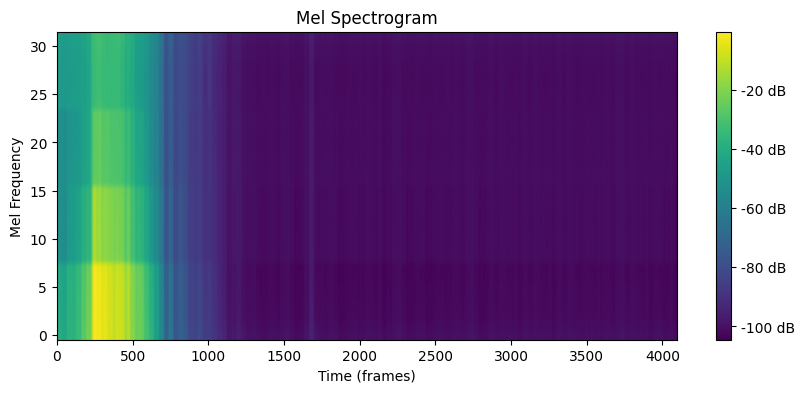

In [11]:
plt.figure(figsize=(10, 4))
plt.imshow(oo[0][0], aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Frequency")
plt.title("Mel Spectrogram")

In [12]:
from vocoder import mel_to_wave

/Users/ares/Library/Caches/pypoetry/virtualenvs/dsvae-PfP47jFl-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached
/Users/ares/Library/Caches/pypoetry/virtualenvs/dsvae-PfP47jFl-py3.12/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in f

In [13]:
a = mel_to_wave(oo)

In [28]:
a.shape

torch.Size([2, 1, 1051136])

In [14]:
import torchaudio
torchaudio.save("test.wav", a[0], 96000)